In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101, ResNet50
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [3]:
from google.colab import files
uploaded = files.upload()

Saving TestA.rar to TestA.rar


In [4]:
!apt-get install unrar

!unrar x -o+ TestA.rar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from TestA.rar

Creating    TestA                                                     OK
Creating    TestA/Basophil                                            OK
Extracting  TestA/Basophil/20190526_163027_0.jpg                           0%  OK 
Extracting  TestA/Basophil/20190526_163055_0.jpg                           0%  OK 
Extracting  TestA/Basophil/20190526_163055_1.jpg                           0%  OK 
Extracting  TestA/Basophil/20190526_163055_2.jpg                           0%  OK 
Extracting  TestA/Basophil/20190526_163545_0.jpg                           0%  OK 
Extracting  TestA/Basophil/20190526_163656_0.jpg                        

In [5]:
import os
os.listdir('/content/TestA')

['Monocyte', 'Lymphocyte', 'Basophil', 'Eosinophil', 'Neutrophil']

In [6]:
# 1. Set up path to Raabin dataset
path_to_raabin_test = '/content/TestA'  # should contain 5 class subfolders

# 2. Extract labels from directory structure (handled by flow_from_directory)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32  # same as BloodMNIST

# 4. Data generators (same variable names)
train_generator_64 = train_datagen.flow_from_directory(
    path_to_raabin_test,
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
val_generator_64 = train_datagen.flow_from_directory(
    path_to_raabin_test,
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)
test_generator_64 = test_datagen.flow_from_directory(
    path_to_raabin_test,
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# 5. Set up ResNet50 model (same structure, just 5 output classes)
base_50_64 = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(64, 64, 3)
)

x = base_50_64.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(5, activation="softmax")(x)  # 5 classes for Raabin

model_50_64 = Model(inputs=base_50_64.input, outputs=outputs)

# 6. Compile model (same optimizer, loss, metrics)
model_50_64.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        AUC(name="auc", multi_label=True, num_labels=5)
    ]
)

Found 3474 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 4339 images belonging to 5 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
# 7. Train model (same structure)
history_50_64 = model_50_64.fit(
    train_generator_64,
    epochs=10,
    validation_data=val_generator_64
)

# 8. Save model (same format)
model_50_64.save('ResNet50_raabin_64.h5')
model_50_64.save('ResNet50_raabin_64.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 99s 392ms/step - accuracy: 0.5926 - auc: 0.7801 - loss: 1.1817 - val_accuracy: 0.0197 - val_auc: 0.5000 - val_loss: 8.1709
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9205 - auc: 0.9813 - loss: 0.2396 - val_accuracy: 0.0197 - val_auc: 0.5287 - val_loss: 5.2442
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9514 - auc: 0.9912 - loss: 0.1428 - val_accuracy: 0.6150 - val_auc: 0.5000 - val_loss: 9.9263
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.9670 - auc: 0.9963 - loss: 0.1041 - val_accuracy: 0.6150 - val_auc: 0.5002 - val_loss: 8.9309
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.9728 - auc: 0.9982 - loss: 0.0698 - val_accuracy: 0.6150 - val_auc: 0.5043 - val_loss: 7.3678
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9772 - auc: 0.9946 - loss: 0.0647 - val_accuracy: 0.5618 - val_auc: 0.5159 - val_loss: 3.7110
Epoch 7/10
109/109 ━━━

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 211ms/step
              precision    recall  f1-score   support

    basophil       0.76      0.94      0.84        17
  eosinophil       0.78      0.83      0.80        64
  lymphocyte       0.96      0.72      0.83       206
    monocyte       0.26      0.89      0.40        46
  neutrophil       0.97      0.85      0.91       532

    accuracy                           0.82       865
   macro avg       0.75      0.85      0.76       865
weighted avg       0.91      0.82      0.85       865

basophil             accuracy: 0.9412
eosinophil           accuracy: 0.8281
lymphocyte           accuracy: 0.7233
monocyte             accuracy: 0.8913
neutrophil           accuracy: 0.8477


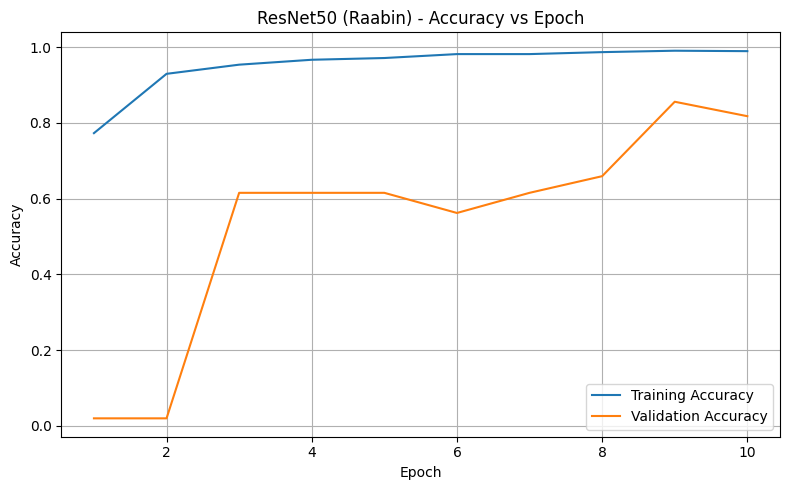

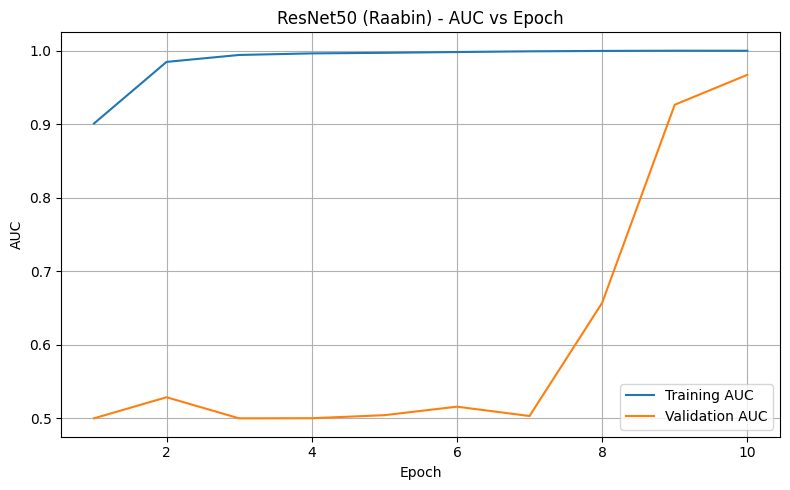

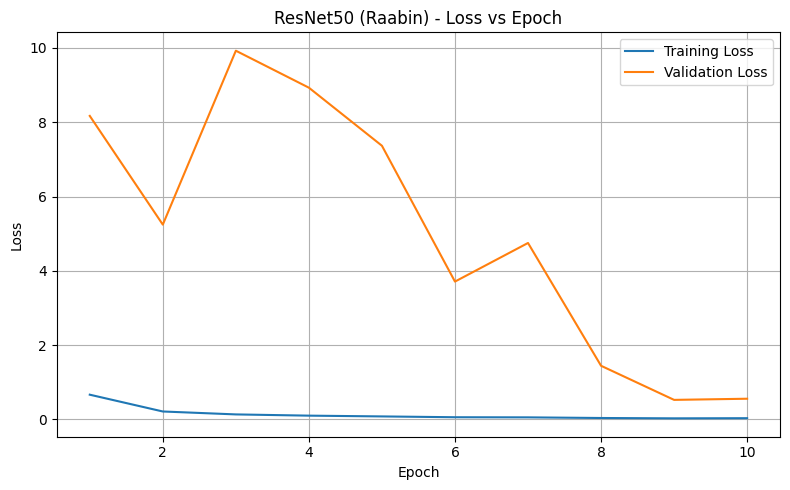

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# 1. Predict probabilities
y_prob_50_64 = model_50_64.predict(val_generator_64, verbose=1)

# 2. Convert to predicted class labels
y_pred_50_64 = np.argmax(y_prob_50_64, axis=1)

# 3. True labels
y_true_64 = val_generator_64.classes

# 4. Class label names (Raabin-WBC, 5 classes)
label_dict_raabin = {
    "0": "basophil",
    "1": "eosinophil",
    "2": "lymphocyte",
    "3": "monocyte",
    "4": "neutrophil"
}
class_names_64 = [label_dict_raabin[str(i)] for i in range(5)]

# 5. Classification report
print(classification_report(y_true_64, y_pred_50_64, target_names=class_names_64))

# 6. Confusion matrix + per-class accuracy
cm_50_64 = confusion_matrix(y_true_64, y_pred_50_64)
per_class_acc_50_64 = cm_50_64.diagonal() / cm_50_64.sum(axis=1)

for i, acc in enumerate(per_class_acc_50_64):
    print(f"{class_names_64[i]:<20s} accuracy: {acc:.4f}")

# 7. Plot training history
epochs = range(1, len(history_50_64.history['loss']) + 1)

# Accuracy plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_64.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_50_64.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 (Raabin) - Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_plot_raabin_resnet50.tiff")
plt.show()

# AUC plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_64.history['auc'], label='Training AUC')
plt.plot(epochs, history_50_64.history['val_auc'], label='Validation AUC')
plt.title('ResNet50 (Raabin) - AUC vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("auc_plot_raabin_resnet50.tiff")
plt.show()

# Loss plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_64.history['loss'], label='Training Loss')
plt.plot(epochs, history_50_64.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 (Raabin) - Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_plot_raabin_resnet50.tiff")
plt.show()

In [10]:
from google.colab import files
files.download("accuracy_plot_raabin_resnet50.tiff")
files.download("auc_plot_raabin_resnet50.tiff")
files.download("loss_plot_raabin_resnet50.tiff")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Class: Basophil | Image: 20190526_165423_0.jpg
Predicted class index: 0


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 64, 64, 3))
  warnings.warn(msg)


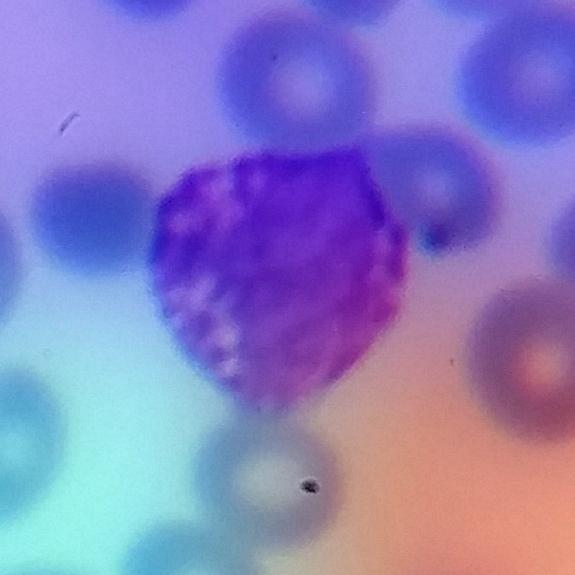


Class: Eosinophil | Image: 95-8-27-1_320_4.jpg
Predicted class index: 1


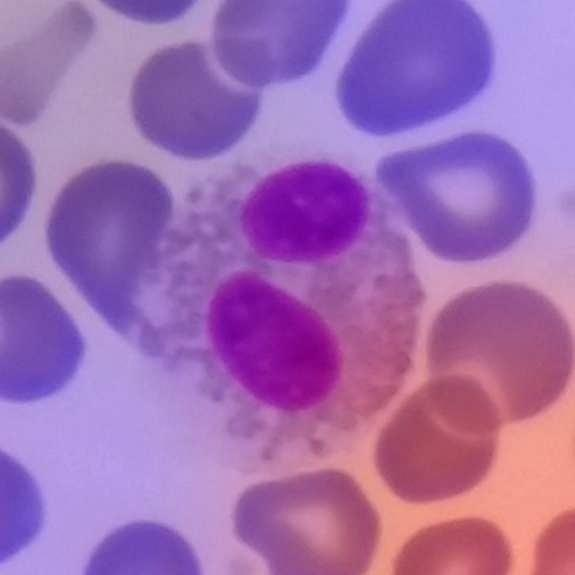


Class: Lymphocyte | Image: 95-8-17-1_65_1.jpg
Predicted class index: 3


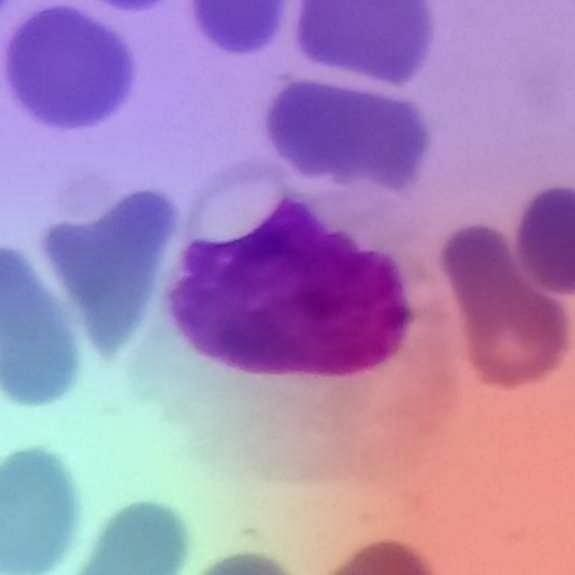


Class: Monocyte | Image: 95-8-17-4_102_1.jpg
Predicted class index: 3


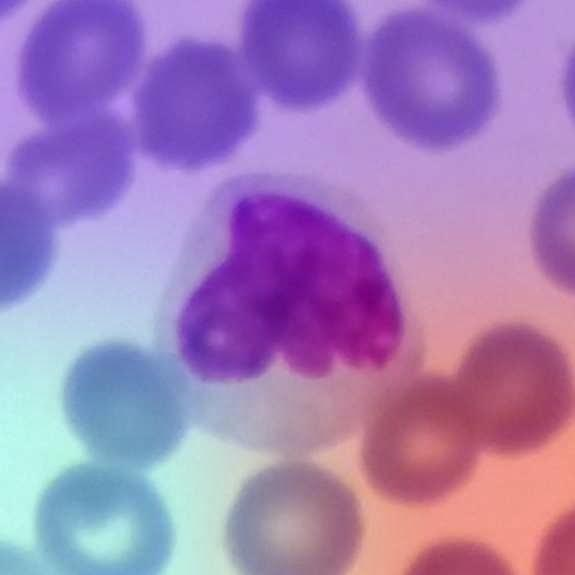


Class: Neutrophil | Image: 95-8-22-5_101_2.jpg
Predicted class index: 4


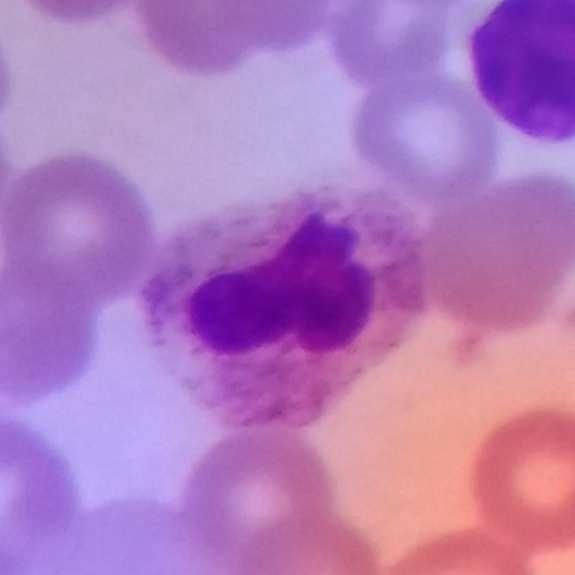

In [9]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
from IPython.display import display

# --- Model and preprocessing ---
model = model_50_64
img_size = (64, 64)
preprocess_input = lambda x: x / 255.0
last_conv_layer_name = "conv5_block3_out"

# --- Grad-CAM helpers ---
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, save_dir="gradcam_outputs/Raabin_ResNet50_64", alpha=0.4):
    os.makedirs(save_dir, exist_ok=True)
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = mpl.colormaps['jet']
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    img_filename = os.path.basename(img_path)
    img_name_no_ext = os.path.splitext(img_filename)[0]
    cam_filename = f"{img_name_no_ext}_gradcam.jpg"
    full_path = os.path.join(save_dir, cam_filename)

    superimposed_img.save(full_path)
    display(Image.open(full_path))

# --- Run Grad-CAM on one image per class ---
root_dir = '/content/TestA'
classes = sorted(os.listdir(root_dir))

for cls in classes:
    class_dir = os.path.join(root_dir, cls)
    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    if not images:
        continue
    img_file = random.choice(images)
    img_path = os.path.join(class_dir, img_file)

    print(f"\nClass: {cls} | Image: {img_file}")
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    img_tensor = tf.convert_to_tensor(img_array)
    preds = model(img_tensor, training=False)
    pred_class = np.argmax(preds[0])
    print("Predicted class index:", pred_class)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    save_and_display_gradcam(img_path, heatmap)


In [20]:
import shutil
gradcam_dir = "/content/gradcam_outputs/Raabin_ResNet50_64"

if os.path.exists(gradcam_dir) and len(os.listdir(gradcam_dir)) > 0:
    zip_path = "/content/gradcam_raabin.zip"
    shutil.make_archive("/content/gradcam_raabin", 'zip', gradcam_dir)
    files.download(zip_path)
else:
    print("No Grad-CAM images found in:", gradcam_dir)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>